In [1]:
import time
import os
import torch
from torch import nn
import torch.nn.functional as F

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
#ONLY RUN THIS ONCE
os.chdir("..")
os.path.abspath(os.curdir)

'/Users/claireboyd/courses/advanced_ml/dirty_comments_and_clean_plates'

#### Custom DataLoaders
Use classes and functions created in model_framework.py to frame out 4 different models using pytorch dataloaders...

In [3]:
import model_framework

In [4]:
train = pd.read_csv("data/phila/split/train.csv")
#subset for only features that are floats or ints
train = train.select_dtypes(include=[np.float64,np.int64])
ALL_FEATURES = list(train.columns)
print(ALL_FEATURES)

['stars', 'review_count', 'is_open', 'n_reviews', 'avg_rating', 'IR_regular', 'IR_follow_up', 'IR_other', 'Chester', 'Bucks', 'Philadelphia', 'Delaware', 'Montgomery', 'Berks', 'Nightlife', 'Bars', 'Pizza', 'Italian', 'Sandwiches', 'Breakfast & Brunch', 'Cafes', 'Burgers', 'Delis', 'Caterers', 'Mexican', 'Desserts', 'Salad', 'Sports Bars', 'Pubs', 'Chicken Wings', 'Seafood', 'Beer', 'Wine & Spirits', 'Juice Bars & Smoothies', 'Mediterranean', 'Gastropubs', 'Diners', 'Steakhouses', 'Breweries', 'Donuts', 'Barbeque', 'Cheesesteaks', 'Middle Eastern', 'Wineries', 'Indian', 'Halal', 'Vegan', 'Vegetarian', 'Beer Bar', 'Soup', 'Sushi Bars']


In [5]:
train_dataset = model_framework.ReviewsDataset(vectorizer=model_framework.Vectorizer,
                              df_filepath="data/phila/split/train.csv",
                              features=ALL_FEATURES)
val_dataset = model_framework.ReviewsDataset(vectorizer=model_framework.Vectorizer,
                              df_filepath="data/phila/split/val.csv",
                              features=ALL_FEATURES)
test_dataset = model_framework.ReviewsDataset(vectorizer=model_framework.Vectorizer,
                              df_filepath="data/phila/split/test.csv",
                              features=ALL_FEATURES)

In [6]:
example = next(iter(train_dataset))
example

{'text': array([0., 0., 0., ..., 0., 0., 0.]),
 'labels': 0,
 'features': array([3. , 5. , 1. , 2. , 2.5, 1. , 0. , 0. , 1. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])}

#### Model Testing

In [7]:
# wrap with any params here: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [8]:
example = next(iter(train_dataloader))
example

{'text': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0546,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 1, 0, 0, 0]),
 'features': tensor([[  4.0000,  81.0000,   1.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  3.0000, 149.0000,   1.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  2.5000,  34.0000,   1.0000,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [  4.0000,  11.0000,   1.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  2.0000,   6.0000,   1.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  4.5000,  17.0000,   1.0000,  ...,   0

In [9]:
def get_accuracy(val_dataloader, model):
    model.eval()
    
    with torch.no_grad():
        n_correct = 0
        n_examples = 0
        for data in val_dataloader:
            # get predicted probabilities, and labels with highest probability
            predicted_labels = model(data['text'])
            # print(predicted_labels)
            # print(data['text'])
            # count correct predictions & update counts
            batch_correct = (predicted_labels == data['labels']).sum().item()
            n_correct += batch_correct
            n_examples += len(data['labels'])
    
    # calculate average accuracy across all batches
    average_accuracy = n_correct / n_examples
    return average_accuracy

In [10]:
def train_model(model, train_dataloader, val_dataloader, optimizer, loss_function, epochs):
    model.train() # Sets the module in training mode.
    val_accuracies=[]
    
    for n_epoch in range(epochs):
        for data in train_dataloader:
            optimizer.zero_grad()
            y_hat = model(data['text'])
            loss = loss_function(y_hat, data['labels'])
            loss.backward()
            optimizer.step()
        val_accuracies.append(get_accuracy(val_dataloader, model))
        
        if n_epoch % 100 == 0:
            print(f'At epoch {n_epoch} the loss is {loss:.3f}.')
    return val_accuracies

In [11]:
def plot_accuracies(val_accuracies):  
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies)

#### SVM

In [12]:
class Binary_SVM(nn.Module):
    def __init__(self, n_features):
        super(Binary_SVM, self).__init__()
        self.linear = nn.Linear(n_features, 1)
        self.nonlinearity = nn.Sigmoid()
    
    def forward(self, x):
        out = self.linear(x)
        #NOTABLY NO NON-LINEAR LAYER?
        out = self.nonlinearity(out)
        out = out.squeeze()
        return out

In [14]:
max_features=7000
svm_model = Binary_SVM(max_features)
epochs=300
lr = 0.01
optimizer = torch.optim.SGD(svm_model.parameters(), lr=lr)
loss_function = torch.nn.NLLLoss()

swm_val_accuracies = train_model(svm_model, train_dataloader, val_dataloader, optimizer, loss_function, epochs)

At epoch 0 the loss is -0.534.
At epoch 100 the loss is -0.981.
At epoch 200 the loss is -0.991.


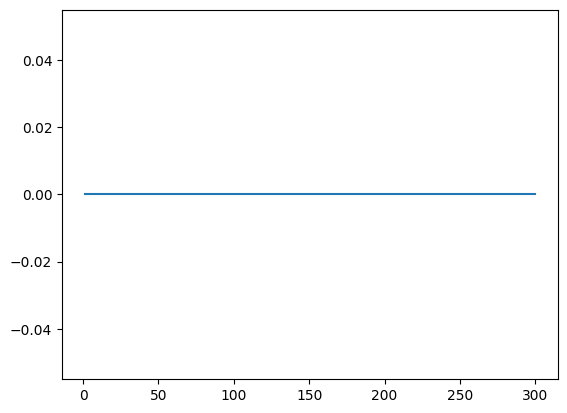

In [15]:
# why is this happening? lol
plot_accuracies(swm_val_accuracies)

### Logistic Regression

In [16]:
class LogisticRegression(torch.nn.Module):    
    def __init__(self, n_inputs, n_outputs):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
        self.nonlinearity = nn.Sigmoid()

    def forward(self, x):
        y_pred = self.nonlinearity(self.linear(x))
        return y_pred

In [17]:
# ADD THE RIGHT DIMENSIONS HERE?
n_inputs = 7000
n_outputs = 32

log_regr_model = LogisticRegression(n_inputs, n_outputs)
epochs=300
lr = 0.01
optimizer = torch.optim.SGD(log_regr_model.parameters(), lr=lr)
loss_function = torch.nn.CrossEntropyLoss()

swm_val_accuracies = train_model(log_regr_model, train_dataloader, val_dataloader, optimizer, loss_function, epochs)

RuntimeError: The size of tensor a (32) must match the size of tensor b (24) at non-singleton dimension 1

### XGBoost